In [75]:
import pandas as pd
from read_db.CH import Getch
import pandahouse
from datetime import date,timedelta, datetime
import telegram
import seaborn as sns
import matplotlib.pyplot as plt
import io
sns.set(style ='ticks')

In [76]:
token = '5368668226:AAGZNDxvxf83GApSiJqi5ahEkIHDXzV52Nw'
bot = telegram.Bot(token = token)

In [77]:
updates = bot.getUpdates()
print(updates[-2])

{'message': {'photo': [], 'new_chat_members': [{'username': 'NewJekaBot', 'is_bot': True, 'first_name': 'KC JekaO bot', 'id': 5368668226}], 'delete_chat_photo': False, 'channel_chat_created': False, 'group_chat_created': False, 'date': 1654497029, 'message_id': 2196, 'entities': [], 'new_chat_photo': [], 'caption_entities': [], 'supergroup_chat_created': False, 'chat': {'all_members_are_administrators': False, 'title': '20.05.22 karpov.courses Симулятор аналитика | АЛЕРТЫ', 'type': 'group', 'id': -652068442}, 'from': {'username': 'jeka_pe4enka', 'is_bot': False, 'language_code': 'ru', 'first_name': 'Jeka', 'id': 400853280}}, 'update_id': 465248823}


In [78]:
chat_id = -652068442

- Переодичность 15 минут
- Активные пользователи (лента, мессенджер)
- Лайки, просмотры, CTR
- Отправленные сообщения

1. Начнем сравнения с прошлым периодом (вчера и прошлая неделя)

!!!Добавить ссылки

In [79]:
data = Getch(
    '''
    select user_id
        ,post_id
        ,action
        ,toStartOfFifteenMinutes(time) as FifteenMinutes
    from simulator_20220520.feed_actions 
    where toDate(time) = today() or toDate(time) = today()-1 or toDate(time) = today() -7
    group by user_id,post_id,action,FifteenMinutes
    '''
    ).df
data.head(1000)

,user_id,post_id,action,FifteenMinutes
0,10750,4554,view,2022-05-30 14:15:00
1,138410,4600,view,2022-05-30 20:00:00
2,52554,5049,view,2022-06-06 09:30:00
3,109115,5122,view,2022-06-06 09:45:00
4,9486,4550,view,2022-05-30 19:15:00
...,...,...,...,...
995,36395,4962,view,2022-06-05 09:45:00
996,137689,4968,like,2022-06-06 09:00:00
997,166755,4491,view,2022-05-30 11:15:00
998,108129,4923,like,2022-06-05 01:00:00


In [80]:
data.shape

(1990212, 4)

In [81]:
yesterday = (date.today() - timedelta(days=1)).strftime('%d-%m-%Y')
yesterday

'05-06-2022'

In [82]:
datetime.now()+ timedelta(hours =3)

datetime.datetime(2022, 6, 6, 10, 32, 56, 573604)

In [83]:
def ceil_dt(dt, delta):
    dt = dt + timedelta(hours =3)
    return dt - (dt - datetime.min) % delta

now = datetime.now()
print(now)    
print(ceil_dt(now, timedelta(minutes=15)))

2022-06-06 07:32:56.582662
2022-06-06 10:30:00


In [84]:
now_time = ceil_dt(now, timedelta(minutes=15)).strftime("%Y-%m-%d %H:%M:%S")
now_time

'2022-06-06 10:30:00'

In [85]:
check_time = data[data["FifteenMinutes"] < now_time].FifteenMinutes.max()
check_time

Timestamp('2022-06-06 10:15:00')

In [86]:
check_time = data[data["FifteenMinutes"] < now_time].FifteenMinutes.max()
check_time_yesterday = check_time - timedelta(days=1)
check_time_last_week = check_time - timedelta(days=7)
check_time_last_minutes = check_time - timedelta(minutes=15)
print(check_time,check_time_yesterday,check_time_last_week,check_time_last_minutes)

2022-06-06 10:15:00 2022-06-05 10:15:00 2022-05-30 10:15:00 2022-06-06 10:00:00


In [87]:
data[data["FifteenMinutes"] < now_time]\
.groupby('FifteenMinutes', as_index = False)\
.agg({'post_id':'count'})\
.sort_values('FifteenMinutes',ascending =False)\
.head(3)

,FifteenMinutes,post_id
233,2022-06-06 10:15:00,10008
232,2022-06-06 10:00:00,9419
231,2022-06-06 09:45:00,10587


In [88]:
data = data[(data["FifteenMinutes"] == check_time) | \
     (data["FifteenMinutes"] == check_time_yesterday) | \
     (data["FifteenMinutes"] == check_time_last_week)| \
     (data["FifteenMinutes"] == check_time_last_minutes)] 
data['type'] = data['FifteenMinutes'].apply(lambda x: "1.today" if x == check_time else\
                                                    ("3.yesteday" if x == check_time_yesterday else \
                                                    ("4.last_week"if x == check_time_last_week else \
                                                    "2.minutes")))
data

,user_id,post_id,action,FifteenMinutes,type
43,160514,4990,view,2022-06-06 10:00:00,2.minutes
60,71782,4787,view,2022-06-06 10:15:00,1.today
78,115838,4565,view,2022-05-30 10:15:00,4.last_week
115,166470,4822,view,2022-06-05 10:15:00,3.yesteday
139,158571,4551,like,2022-05-30 10:15:00,4.last_week
...,...,...,...,...,...
1989964,17430,4923,view,2022-06-05 10:15:00,3.yesteday
1990015,135767,4853,like,2022-06-06 10:15:00,1.today
1990150,145243,4982,view,2022-06-06 10:00:00,2.minutes
1990172,159430,4939,view,2022-06-06 10:00:00,2.minutes


In [89]:
pivot_data = data.pivot_table(index ="action",
                 columns = "type",
                 values = "user_id",
                 aggfunc ="count",
                 fill_value = 0)
pivot_data

type,1.today,2.minutes,3.yesteday,4.last_week
action,,,,
like,1791,1637,1852,1604
view,8217,7782,8626,7183


In [90]:
pivot_data['dif_t_m']=(pivot_data['1.today']/pivot_data['2.minutes']-1).round(2)
pivot_data['dif_t_y']=(pivot_data['1.today']/pivot_data['3.yesteday']-1).round(2)
pivot_data['dif_t_w']=(pivot_data['1.today']/pivot_data['4.last_week']-1).round(2)
pivot_data

type,1.today,2.minutes,3.yesteday,4.last_week,dif_t_m,dif_t_y,dif_t_w
action,,,,,,,
like,1791,1637,1852,1604,0.09,-0.03,0.12
view,8217,7782,8626,7183,0.06,-0.05,0.14


НОВОСТИ

In [91]:
data_news = Getch(
                        '''
                        select 
                        toStartOfFifteenMinutes(time) as FifteenMinutes,
                        count(distinct user_id) as dau_news, 
                        countIf(post_id, action = 'view') as view, 
                        countIf(post_id, action = 'like') as like, 
                        countIf(post_id, action = 'like')/countIf(post_id, action = 'view') as CTR 
                        from simulator_20220520.feed_actions as f
                        where toDate(time) = today() or toDate(time) = today()-1 or toDate(time) = today() -7
                        group by FifteenMinutes
                        '''
                        ).df

In [167]:
data_from_base = Getch(
            '''
            with f as (
                    select 
                        toStartOfFifteenMinutes(time) as FifteenMinutes
                        ,toDate(FifteenMinutes) as date
                        ,formatDateTime(FifteenMinutes, '%R') as hm
                        ,count(distinct user_id) as dau_news
                        ,countIf(post_id, action = 'view') as view
                        ,countIf(post_id, action = 'like') as like
                        ,countIf(post_id, action = 'like')/countIf(post_id, action = 'view') as CTR
                    from simulator_20220520.feed_actions
                    group by FifteenMinutes,date,hm
            ),
            m as (select 
                        toStartOfFifteenMinutes(time) as FifteenMinutes
                        ,count(distinct user_id) as dau_message
                        ,count(user_id) as count_message 
                    from simulator_20220520.message_actions 
                    group by FifteenMinutes
            )

            select f.FifteenMinutes as FifteenMinutes
                ,f.date as date
                ,f.hm as hm
                ,f.dau_news as dau_news
                ,f.view as view
                ,f.like as like
                ,f.CTR as CTR
                ,m.dau_message as dau_message
                ,m.count_message as count_message
            from f
            --where toDate(time) = today() or toDate(time) = today()-1 or toDate(time) = today() -7
            full join m 
            using FifteenMinutes
            '''
            ).df

In [168]:
data_from_base.dtypes

FifteenMinutes    datetime64[ns]
date              datetime64[ns]
hm                        object
dau_news                  uint64
view                      uint64
like                      uint64
CTR                      float64
dau_message               uint64
count_message             uint64
dtype: object

In [169]:
def ceil_dt(dt, delta):
    dt = dt + timedelta(hours =3)
    return dt - (dt - datetime.min) % delta

now = datetime.now()
print(now)    
print(ceil_dt(now, timedelta(minutes=15)))

2022-06-06 08:35:32.056104
2022-06-06 11:30:00


In [170]:
now

datetime.datetime(2022, 6, 6, 8, 35, 32, 56104)

In [171]:
now_time = ceil_dt(now, timedelta(minutes=15)).strftime("%Y-%m-%d %H:%M:%S")
now_time

'2022-06-06 11:30:00'

In [172]:
#now_time = '2022-05-28 23:00:00'

In [173]:
data_from_base[data_from_base["FifteenMinutes"] == now_time]

,FifteenMinutes,date,hm,dau_news,view,like,CTR,dau_message,count_message
2237,2022-06-06 11:30:00,2022-06-06,11:30,345,3100,685,0.220968,103,122


In [174]:
data_from_base =data_from_base[data_from_base["FifteenMinutes"] < now_time]

In [175]:
check_time = data_from_base[data_from_base["FifteenMinutes"] < now_time].FifteenMinutes.max()
check_time_yesterday = check_time - timedelta(days=1)
check_time_last_week = check_time - timedelta(days=7)
check_time_last_minutes = check_time - timedelta(minutes=15)
check_minutes = data_from_base[data_from_base["FifteenMinutes"] ==  check_time].hm.max()
print(check_time,check_time_yesterday,check_time_last_week,check_time_last_minutes, check_minutes)

2022-06-06 11:15:00 2022-06-05 11:15:00 2022-05-30 11:15:00 2022-06-06 11:00:00 11:15


In [176]:
yesterday = (date.today() - timedelta(days=1)).strftime('%Y-%m-%d')
today = date.today().strftime('%Y-%m-%d')
last_week = (date.today() - timedelta(days=7)).strftime('%Y-%m-%d')
period = [today,yesterday,last_week]
period 

['2022-06-06', '2022-06-05', '2022-05-30']

In [177]:
data = data_from_base 

In [178]:
data = data[(data["FifteenMinutes"] == check_time) | \
     (data["FifteenMinutes"] == check_time_yesterday) | \
     (data["FifteenMinutes"] == check_time_last_week)| \
     (data["FifteenMinutes"] == check_time_last_minutes)] 
data['type'] = data['FifteenMinutes'].apply(lambda x: "1.today" if x == check_time else\
                                                    ("3.yesteday" if x == check_time_yesterday else \
                                                    ("4.last_week"if x == check_time_last_week else \
                                                    "2.minutes")))
data

/tmp/ipykernel_65/1207634613.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['type'] = data['FifteenMinutes'].apply(lambda x: "1.today" if x == check_time else\


,FifteenMinutes,date,hm,dau_news,view,like,CTR,dau_message,count_message,type
1551,2022-05-30 11:15:00,2022-05-30,11:15,618,7603,1697,0.223201,133,186,4.last_week
3830,2022-06-06 11:00:00,2022-06-06,11:00,629,8428,1877,0.222710,137,177,2.minutes
4571,2022-06-05 11:15:00,2022-06-05,11:15,612,8890,1896,0.213273,128,187,3.yesteday
5359,2022-06-06 11:15:00,2022-06-06,11:15,616,8355,1810,0.216637,129,168,1.today


In [179]:
pivot_data = data.drop(columns=['FifteenMinutes', 'date','hm']).sort_values('type').set_index('type').T.reset_index()
pivot_data

type,index,1.today,2.minutes,3.yesteday,4.last_week
0,dau_news,616.000000,629.00000,612.000000,618.000000
1,view,8355.000000,8428.00000,8890.000000,7603.000000
2,like,1810.000000,1877.00000,1896.000000,1697.000000
3,CTR,0.216637,0.22271,0.213273,0.223201
4,dau_message,129.000000,137.00000,128.000000,133.000000
5,count_message,168.000000,177.00000,187.000000,186.000000


In [180]:
thereshold = 0.2

In [181]:
data_from_base

,FifteenMinutes,date,hm,dau_news,view,like,CTR,dau_message,count_message
0,2022-05-18 20:45:00,2022-05-18,20:45,616,8080,1741,0.215470,131,202
1,2022-05-30 19:15:00,2022-05-30,19:15,783,10470,2215,0.211557,155,237
2,2022-04-26 04:30:00,2022-04-26,04:30,133,1466,301,0.205321,34,37
3,2022-06-01 09:15:00,2022-06-01,09:15,575,6890,1394,0.202322,109,154
4,2022-05-27 16:30:00,2022-05-27,16:30,708,5944,1121,0.188594,141,194
...,...,...,...,...,...,...,...,...,...
6762,2022-04-08 23:30:00,2022-04-08,23:30,212,3977,871,0.219009,47,72
6763,2022-05-26 12:00:00,2022-05-26,12:00,620,5439,1059,0.194705,131,192
6764,2022-04-27 03:00:00,2022-04-27,03:00,150,2165,500,0.230947,67,84
6765,2022-04-20 01:15:00,2022-04-20,01:15,225,3889,782,0.201080,65,79


In [182]:
['Metrics','Chart_url','Dash_url'],

(['Metrics', 'Chart_url', 'Dash_url'],)

In [184]:
voc = pd.DataFrame(
       [['dau_news','http://superset.lab.karpov.courses/r/1241', 'https://superset.lab.karpov.courses/superset/dashboard/988/'], 
       ['view','http://superset.lab.karpov.courses/r/1243',  'https://superset.lab.karpov.courses/superset/dashboard/988/'], 
       ['like','http://superset.lab.karpov.courses/r/1242',  'https://superset.lab.karpov.courses/superset/dashboard/988/'], 
       ['CTR','http://superset.lab.karpov.courses/r/1244',  'https://superset.lab.karpov.courses/superset/dashboard/988/'], 
       ['dau_message','http://superset.lab.karpov.courses/r/1245',  'https://superset.lab.karpov.courses/superset/dashboard/988/'], 
       ['count_message','http://superset.lab.karpov.courses/r/1246',  'https://superset.lab.karpov.courses/superset/dashboard/988/']]\
        , columns=['Metrics','Chart_url','Dash_url'])
voc

,Metrics,Chart_url,Dash_url
0,dau_news,http://superset.lab.karpov.courses/r/1241,https://superset.lab.karpov.courses/superset/d...
1,view,http://superset.lab.karpov.courses/r/1243,https://superset.lab.karpov.courses/superset/d...
2,like,http://superset.lab.karpov.courses/r/1242,https://superset.lab.karpov.courses/superset/d...
3,CTR,http://superset.lab.karpov.courses/r/1244,https://superset.lab.karpov.courses/superset/d...
4,dau_message,http://superset.lab.karpov.courses/r/1245,https://superset.lab.karpov.courses/superset/d...
5,count_message,http://superset.lab.karpov.courses/r/1246,https://superset.lab.karpov.courses/superset/d...


In [196]:
data_from_base[(data_from_base["hm"] == check_minutes) & (data_from_base["date"] > last_week)].sort_values('date')

,FifteenMinutes,date,hm,dau_news,view,like,CTR,dau_message,count_message
936,2022-05-31 11:15:00,2022-05-31,11:15,620,7511,1654,0.220210,99,116
3756,2022-06-01 11:15:00,2022-06-01,11:15,591,6380,1322,0.207210,131,178
6348,2022-06-02 11:15:00,2022-06-02,11:15,605,5345,1106,0.206922,136,179
3520,2022-06-03 11:15:00,2022-06-03,11:15,595,4656,922,0.198024,146,185
1376,2022-06-04 11:15:00,2022-06-04,11:15,596,7465,1484,0.198794,125,189
4571,2022-06-05 11:15:00,2022-06-05,11:15,612,8890,1896,0.213273,128,187
5359,2022-06-06 11:15:00,2022-06-06,11:15,616,8355,1810,0.216637,129,168


СТАТИСТИЧЕСКИЕ МЕТОДЫ

In [185]:
data_from_base[(data_from_base["hm"] == check_minutes) & (data_from_base["date"] > last_week)].sort_values('date').rolling(5,min_periods=1).mean().round(0)

,dau_news,view,like,CTR,dau_message,count_message
936,620.0,7511.0,1654.0,0.0,99.0,116.0
3756,606.0,6946.0,1488.0,0.0,115.0,147.0
6348,605.0,6412.0,1361.0,0.0,122.0,158.0
3520,603.0,5973.0,1251.0,0.0,128.0,164.0
1376,601.0,6271.0,1298.0,0.0,127.0,169.0
4571,600.0,6547.0,1346.0,0.0,133.0,184.0
5359,605.0,6942.0,1444.0,0.0,133.0,182.0


In [186]:
a =2

In [187]:
std = data_from_base[['dau_news','view','like','CTR','dau_message','count_message']][(data_from_base["hm"] == check_minutes) & (data_from_base["date"] > last_week)]\
.agg(['std','mean'])\
.T\
.reset_index()\
#.rename(columns={0:'std'})
std['mins'] = (std['mean'] - 3*std['std']).round(0)
std['maxs'] = (std['mean'] + 3*std['std']).round(0)
std

,index,std,mean,mins,maxs
0,dau_news,11.343133,605.000000,571.0,639.0
1,view,1553.523032,6943.142857,2283.0,11604.0
2,like,361.597250,1456.285714,371.0,2541.0
3,CTR,0.008504,0.208724,0.0,0.0
4,dau_message,14.418903,127.714286,84.0,171.0
5,count_message,25.558523,171.714286,95.0,248.0


In [188]:
quantile = data_from_base[(data_from_base["hm"] == check_minutes) & (data_from_base["date"] > last_week)].quantile([0.25,0.5,0.75]).T

In [189]:
quantile['IQR'] =(quantile[0.75] - quantile[0.25])
quantile = quantile.reset_index().rename(columns = {0.25:'25q',0.75:'75q',0.5:'50q'})
quantile['minq'] = quantile['25q'] -  a*quantile['IQR']
quantile['maxq'] = quantile['75q'] +  a*quantile['IQR']
quantile

,index,25q,50q,75q,IQR,minq,maxq
0,dau_news,595.500000,605.00000,614.000000,18.500000,558.500000,651.000000
1,view,5862.500000,7465.00000,7933.000000,2070.500000,1721.500000,12074.000000
2,like,1214.000000,1484.00000,1732.000000,518.000000,178.000000,2768.000000
3,CTR,0.202858,0.20721,0.214955,0.012097,0.178665,0.239148
4,dau_message,126.500000,129.00000,133.500000,7.000000,112.500000,147.500000
5,count_message,173.000000,179.00000,186.000000,13.000000,147.000000,212.000000


In [190]:
pivot_data = pivot_data.merge(std).merge(quantile)

In [191]:
pivot_data

,index,1.today,2.minutes,3.yesteday,4.last_week,std,mean,mins,maxs,25q,50q,75q,IQR,minq,maxq
0,dau_news,616.000000,629.00000,612.000000,618.000000,11.343133,605.000000,571.0,639.0,595.500000,605.00000,614.000000,18.500000,558.500000,651.000000
1,view,8355.000000,8428.00000,8890.000000,7603.000000,1553.523032,6943.142857,2283.0,11604.0,5862.500000,7465.00000,7933.000000,2070.500000,1721.500000,12074.000000
2,like,1810.000000,1877.00000,1896.000000,1697.000000,361.597250,1456.285714,371.0,2541.0,1214.000000,1484.00000,1732.000000,518.000000,178.000000,2768.000000
3,CTR,0.216637,0.22271,0.213273,0.223201,0.008504,0.208724,0.0,0.0,0.202858,0.20721,0.214955,0.012097,0.178665,0.239148
4,dau_message,129.000000,137.00000,128.000000,133.000000,14.418903,127.714286,84.0,171.0,126.500000,129.00000,133.500000,7.000000,112.500000,147.500000
5,count_message,168.000000,177.00000,187.000000,186.000000,25.558523,171.714286,95.0,248.0,173.000000,179.00000,186.000000,13.000000,147.000000,212.000000


In [192]:
((pivot_data['1.today'] < pivot_data['minq']) & (pivot_data['1.today'] > pivot_data['maxq']))

0    False
1    False
2    False
3    False
4    False
5    False
dtype: bool

In [193]:
mapping = {True:1, False:0}

In [194]:
pivot_data['dif_t_m'] = (pivot_data['1.today']/pivot_data['2.minutes']-1)
pivot_data['dif_t_y'] = (pivot_data['1.today']/pivot_data['3.yesteday']-1)
pivot_data['dif_t_w'] = (pivot_data['1.today']/pivot_data['4.last_week']-1)
pivot_data['is_alert_d'] = pivot_data['dif_t_y'].apply(lambda x: 1 if x >= abs(thereshold) else 0) #предыдущий день
pivot_data['is_alert_w'] = pivot_data['dif_t_w'].apply(lambda x: 1 if x >= abs(thereshold) else 0) #прошлая неделя
pivot_data['is_alert_q'] = ((pivot_data['1.today'] < pivot_data['minq']) & (pivot_data['1.today'] > pivot_data['maxq'])).map(mapping) #квантили
pivot_data['is_alert_s'] = ((pivot_data['1.today'] < pivot_data['mins']) & (pivot_data['1.today'] > pivot_data['maxs'])).map(mapping) #сигмы
pivot_data['is_alert'] = ((pivot_data['is_alert_d']+pivot_data['is_alert_w']+pivot_data['is_alert_q']+pivot_data['is_alert_s']) >=3 ).map(mapping) #сигнализируем, если три и больше проверки показали алерт
pivot_data

,index,1.today,2.minutes,3.yesteday,4.last_week,std,mean,mins,maxs,25q,...,minq,maxq,dif_t_m,dif_t_y,dif_t_w,is_alert_d,is_alert_w,is_alert_q,is_alert_s,is_alert
0,dau_news,616.000000,629.00000,612.000000,618.000000,11.343133,605.000000,571.0,639.0,595.500000,...,558.500000,651.000000,-0.020668,0.006536,-0.003236,0,0,0,0,0
1,view,8355.000000,8428.00000,8890.000000,7603.000000,1553.523032,6943.142857,2283.0,11604.0,5862.500000,...,1721.500000,12074.000000,-0.008662,-0.060180,0.098908,0,0,0,0,0
2,like,1810.000000,1877.00000,1896.000000,1697.000000,361.597250,1456.285714,371.0,2541.0,1214.000000,...,178.000000,2768.000000,-0.035695,-0.045359,0.066588,0,0,0,0,0
3,CTR,0.216637,0.22271,0.213273,0.223201,0.008504,0.208724,0.0,0.0,0.202858,...,0.178665,0.239148,-0.027270,0.015770,-0.029411,0,0,0,0,0
4,dau_message,129.000000,137.00000,128.000000,133.000000,14.418903,127.714286,84.0,171.0,126.500000,...,112.500000,147.500000,-0.058394,0.007812,-0.030075,0,0,0,0,0
5,count_message,168.000000,177.00000,187.000000,186.000000,25.558523,171.714286,95.0,248.0,173.000000,...,147.000000,212.000000,-0.050847,-0.101604,-0.096774,0,0,0,0,0


In [117]:
alert_data = pivot_data[(pivot_data['is_alert_d'] == 1) | (pivot_data['is_alert_w'] == 1)]\
.reset_index()\
.drop(columns = ['level_0'])
alert_data

,index,1.today,2.minutes,3.yesteday,4.last_week,std,mean,mins,maxs,25q,...,minq,maxq,dif_t_m,dif_t_y,dif_t_w,is_alert_d,is_alert_w,is_alert_q,is_alert_s,is_alert


In [231]:
alert_data.iloc[0]

index          dau_message
1.today              146.0
2.minutes            139.0
3.yesteday           136.0
4.last_week          114.0
std              14.638501
mean            129.428571
mins                  86.0
maxs                 173.0
25q                  129.0
50q                  133.0
75q                  135.0
IQR                    6.0
minq                 123.0
maxq                 141.0
dif_t_m            0.05036
dif_t_y           0.073529
dif_t_w           0.280702
is_alert_d               0
is_alert_w               1
is_alert_q               0
is_alert_ы           False
is_alert_s               0
is_alert                 0
Name: 0, dtype: object

In [232]:
range(alert_data.shape[0]-1)

range(0, 0)

In [233]:
for row in alert_data.index:
    df = alert_data.loc[row]
    print(df[0])

dau_message


In [234]:
metric = alert_data.loc[0][0]
metric

'dau_message'

In [19]:
yesterday = (date.today() - timedelta(days=1)).strftime('%Y-%m-%d')
today = date.today().strftime('%Y-%m-%d')
last_week = (date.today() - timedelta(days=7)).strftime('%Y-%m-%d')
period = [today,yesterday,last_week]
period 

['2022-06-06', '2022-06-05', '2022-05-30']

In [236]:
data_from_base[data_from_base.date.isin(period)]

,FifteenMinutes,date,hm,dau_news,view,like,CTR,dau_message,count_message
4,2022-05-27 16:30:00,2022-05-27,16:30,708,5944,1121,0.188594,141,194
9,2022-05-27 18:15:00,2022-05-27,18:15,738,6394,1183,0.185017,148,216
15,2022-06-02 01:30:00,2022-06-02,01:30,328,4152,863,0.207852,63,68
54,2022-06-02 00:30:00,2022-06-02,00:30,398,5045,1016,0.201388,79,88
65,2022-05-27 17:30:00,2022-05-27,17:30,742,6373,1101,0.172760,140,196
...,...,...,...,...,...,...,...,...,...
6316,2022-05-27 08:45:00,2022-05-27,08:45,539,5500,1085,0.197273,98,125
6348,2022-05-27 02:00:00,2022-05-27,02:00,302,3532,680,0.192525,57,62
6349,2022-05-27 12:00:00,2022-05-27,12:00,649,5685,1080,0.189974,124,185
6372,2022-06-03 07:45:00,2022-06-03,07:45,434,4004,777,0.194056,94,109


In [237]:
alert_data

,index,1.today,2.minutes,3.yesteday,4.last_week,std,mean,mins,maxs,25q,...,maxq,dif_t_m,dif_t_y,dif_t_w,is_alert_d,is_alert_w,is_alert_q,is_alert_ы,is_alert_s,is_alert
0,dau_message,146.0,139.0,136.0,114.0,14.638501,129.428571,86.0,173.0,129.0,...,141.0,0.05036,0.073529,0.280702,0,1,0,False,0,0


[(0.0, 178.9)]

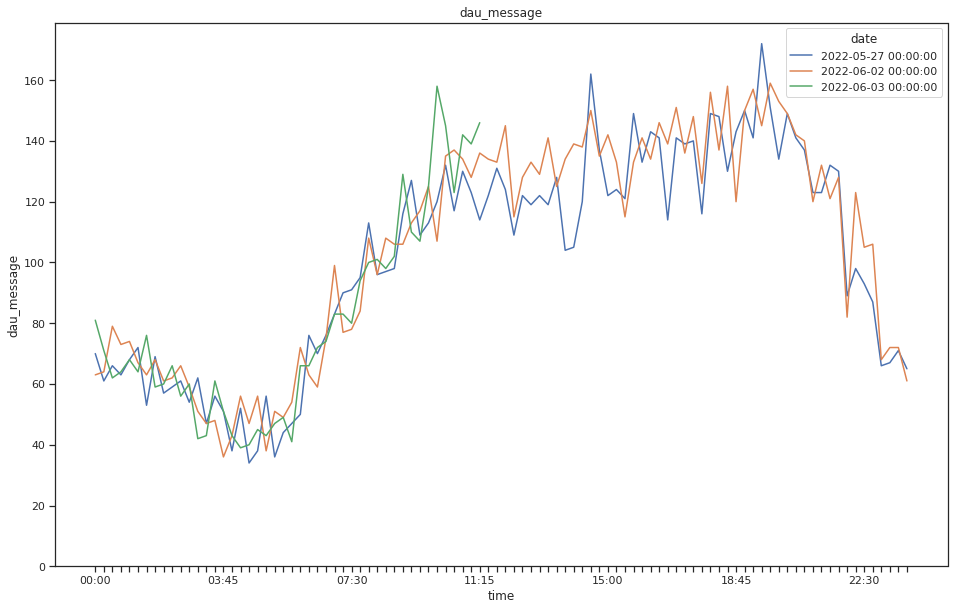

In [238]:
plt.figure(figsize=(16, 10))
plt.tight_layout()
ax = sns.lineplot(data=data_from_base[data_from_base.date.isin(period)].sort_values(by=['date', 'hm']), 
                  x="hm", y=metric, hue="date")
# задаем "группировку" на графике, т е хотим чтобы для каждого значения date была своя линия построена
for ind, label in enumerate(ax.get_xticklabels()): # этот цикл нужен чтобы разрядить подписи координат по оси Х,
    if ind % 15 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
ax.set(xlabel='time') # задаем имя оси Х
ax.set(ylabel=metric) # задаем имя оси У
ax.set_title('{}'.format(metric)) # задаем заголовок графика
ax.set(ylim=(0, None)) # задаем лимит для оси У

In [240]:
alert_data

,index,1.today,2.minutes,3.yesteday,4.last_week,std,mean,mins,maxs,25q,...,maxq,dif_t_m,dif_t_y,dif_t_w,is_alert_d,is_alert_w,is_alert_q,is_alert_ы,is_alert_s,is_alert
0,dau_message,146.0,139.0,136.0,114.0,14.638501,129.428571,86.0,173.0,129.0,...,141.0,0.05036,0.073529,0.280702,0,1,0,False,0,0


In [239]:
token = '5368668226:AAGZNDxvxf83GApSiJqi5ahEkIHDXzV52Nw'
bot = telegram.Bot(token = token)
chat_id =  400853280

In [243]:
for row in alert_data.index:
    df = alert_data.loc[row]
    #if df[8] == 1:
    #    msg = '''
    #        Показатель {metric}:
    #        текущее значение = {current_value:.2f}
    #        отклонение от вчера {diff:.2%}'''.format(metric = df[0]
    #                                                 ,current_value = df[1]
    #                                                 ,diff = df[6])
   # else:    
    #    msg = '''
    #        Показатель {metric}:
    #        текущее значение = {current_value:.2f}
    #        отклонение от прошлой недели {diff:.2%}'''.format(metric = df[0]
    #                                                 ,current_value = df[1]
    #,diff = df[7])
    msg = '''
    Показатель {metric}:
    текущее значение = {current_value:.2f}
    отклонение от вчера {diff:.2%}
    отклонение от прошлой недели {diff2:.2%}
    '''.format(metric = df[0]
               ,current_value = df[1]
               ,diff = df[6]
               ,diff2 = df[7])
    
    
    #рисуем график
    metric = df[0]
    plt.figure(figsize=(16, 10))
    plt.tight_layout()
    ax = sns.lineplot(data=data_from_base[data_from_base.date.isin(period)].sort_values(by=['date', 'hm']), 
                  x="hm", y=metric, hue="date")
    # задаем "группировку" на графике, т е хотим чтобы для каждого значения date была своя линия построена
    for ind, label in enumerate(ax.get_xticklabels()): # этот цикл нужен чтобы разрядить подписи координат по оси Х,
        if ind % 15 == 0:
            label.set_visible(True)
        else:
            label.set_visible(False)
    ax.set(xlabel='time') # задаем имя оси Х
    ax.set(ylabel=metric) # задаем имя оси У
    ax.set_title('{}'.format(metric)) # задаем заголовок графика
    ax.set(ylim=(0, None)) # задаем лимит для оси У


    # формируем файловый объект
    plot_object = io.BytesIO()
    ax.figure.savefig(plot_object)
    plot_object.seek(0)
    plot_object.name = '{0}.png'.format(metric)
    plt.close()

    # отправляем алерт
    bot.sendMessage(chat_id=chat_id, text=msg)
    bot.sendPhoto(chat_id=chat_id, photo=plot_object)

try:
    run_alerts()
except Exception as e:
    print(e)

name 'run_alerts' is not defined


In [68]:
import pandas as pd
from CH import Getch
import pandahouse
from datetime import date,timedelta, datetime
import telegram
import seaborn as sns
import matplotlib.pyplot as plt
import io
sns.set(style ='ticks')

#маркеры времени
#если алерт запустили дополнительно в другое время, берется последняя "полная" запись
def ceil_dt(dt, delta):
    dt = dt + timedelta(hours =3)
    return dt - (dt - datetime.min) % delta

now = datetime.now()
now_time = ceil_dt(now, timedelta(minutes=15)).strftime("%Y-%m-%d %H:%M:%S")

yesterday = (date.today() - timedelta(days=1)).strftime('%d-%m-%Y')
today = date.today().strftime('%d-%m-%Y')
last_week = (date.today() - timedelta(days=7)).strftime('%d-%m-%Y')
period = [today,yesterday,last_week]

In [69]:
    
    #подключаемся к телеге
    chat_id = 400853280
    token = '5368668226:AAGZNDxvxf83GApSiJqi5ahEkIHDXzV52Nw'
    bot = telegram.Bot(token = token)
    
    #выгружаем данные из базы
    data_from_base = Getch(
            '''
            with f as (
                    select 
                        toStartOfFifteenMinutes(time) as FifteenMinutes
                        ,toDate(FifteenMinutes) as date
                        ,formatDateTime(FifteenMinutes, '%R') as hm
                        ,count(distinct user_id) as dau_news
                        ,countIf(post_id, action = 'view') as view
                        ,countIf(post_id, action = 'like') as like
                        ,countIf(post_id, action = 'like')/countIf(post_id, action = 'view') as CTR
                    from simulator_20220520.feed_actions
                    group by FifteenMinutes,date,hm
            ),
            m as (select 
                        toStartOfFifteenMinutes(time) as FifteenMinutes
                        ,count(distinct user_id) as dau_message
                        ,count(user_id) as count_message 
                    from simulator_20220520.message_actions 
                    group by FifteenMinutes
            )

            select f.FifteenMinutes as FifteenMinutes
                ,f.date as date
                ,f.hm as hm
                ,f.dau_news as dau_news
                ,f.view as view
                ,f.like as like
                ,f.CTR as CTR
                ,m.dau_message as dau_message
                ,m.count_message as count_message
            from f
            --where toDate(time) = today() or toDate(time) = today()-1 or toDate(time) = today() -7
            full join m 
            using FifteenMinutes
            '''
            ).df
    
    #порог
    thereshold = 0.2
    
    #маркеры времени для проверки
    check_time = data_from_base[data_from_base["FifteenMinutes"] < now_time].FifteenMinutes.max()
    check_time_yesterday = check_time - timedelta(days=1)
    check_time_last_week = check_time - timedelta(days=7)
    check_time_last_minutes = check_time - timedelta(minutes=15)
    
    #обработка данных:оставляем текущее время и время, с которым идет сверка
    data = data_from_base
    data = data[(data["FifteenMinutes"] == check_time) | \
     (data["FifteenMinutes"] == check_time_yesterday) | \
     (data["FifteenMinutes"] == check_time_last_week)| \
     (data["FifteenMinutes"] == check_time_last_minutes)] 
    
    data['type'] = data['FifteenMinutes'].apply(lambda x: "1.today" if x == check_time else\
                                                    ("3.yesteday" if x == check_time_yesterday else \
                                                    ("4.last_week"if x == check_time_last_week else \
                                                    "2.minutes")))

/tmp/ipykernel_173/1725032402.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['type'] = data['FifteenMinutes'].apply(lambda x: "1.today" if x == check_time else\


In [70]:
data

,FifteenMinutes,date,hm,dau_news,view,like,CTR,dau_message,count_message,type
276,2022-05-26 20:15:00,2022-05-26,20:15,696,7920,1584,0.200000,149,221,4.last_week
885,2022-06-02 20:00:00,2022-06-02,20:00,690,6634,1383,0.208472,153,222,2.minutes
3392,2022-06-01 20:15:00,2022-06-01,20:15,691,8260,1620,0.196126,143,195,3.yesteday
4974,2022-06-02 20:15:00,2022-06-02,20:15,1173,8439,1697,0.201090,149,200,1.today


In [71]:

    
    #разворачиваем таблицу и делаем проверку
    pivot_data = data.drop(columns=['FifteenMinutes','date','hm'])\
                        .sort_values('type').set_index('type').T.reset_index()
    
   
    
    pivot_data['dif_t_m'] = (pivot_data['1.today']/pivot_data['2.minutes']-1)
    pivot_data['dif_t_y'] = (pivot_data['1.today']/pivot_data['3.yesteday']-1)
    pivot_data['dif_t_w'] = (pivot_data['1.today']/pivot_data['4.last_week']-1)
    pivot_data['is_alert_d'] = pivot_data['dif_t_y'].apply(lambda x: 1 if x >= abs(thereshold) else 0)
    pivot_data['is_alert_w'] = pivot_data['dif_t_w'].apply(lambda x: 1 if x >= abs(thereshold) else 0)
    
    #отбираем показатели, по которым нужен алерт
    alert_data = pivot_data[(pivot_data['is_alert_d'] == 1) | (pivot_data['is_alert_w'] == 1)]\
                    .reset_index()\
                    .drop(columns = ['level_0'])

In [72]:
alert_data

type,index,1.today,2.minutes,3.yesteday,4.last_week,dif_t_m,dif_t_y,dif_t_w,is_alert_d,is_alert_w
0,dau_news,1173.0,690.0,691.0,696.0,0.7,0.69754,0.685345,1,1


In [73]:
   #проходим по метрикам и делаем рассылку алертов
    for row in alert_data.index:
        df = alert_data.loc[row]
        if df[8] == 1:
            msg = '''
                Показатель {metric}:
                текущее значение = {current_value:.2f}
                отклонение от вчера {diff:.2%}'''.format(metric = df[0]
                                                         ,current_value = df[1]
                                                         ,diff = df[6])
        else:    
            msg = '''
                Показатель {metric}:
                текущее значение = {current_value:.2f}
                отклонение от прошлой недели {diff:.2%}'''.format(metric = df[0]
                                                         ,current_value = df[1]
                                                         ,diff = df[7])

        #рисуем график
        metric = df[0]
        plt.figure(figsize=(16, 10))
        plt.tight_layout()
        ax = sns.lineplot(data=data_from_base[data_from_base.date.isin(period)].sort_values(by=['date', 'hm']), 
                      x="hm", y=metric, hue="date")
        # этот цикл нужен чтобы разрядить подписи координат по оси Х
        for ind, label in enumerate(ax.get_xticklabels()): 
            if ind % 15 == 0:
                label.set_visible(True)
            else:
                label.set_visible(False)
        ax.set(xlabel='time') # задаем имя оси Х
        ax.set(ylabel=metric) # задаем имя оси У
        ax.set_title('{}'.format(metric)) # задаем заголовок графика
        ax.set(ylim=(0, None)) # задаем лимит для оси У


        # формируем файловый объект
        plot_object = io.BytesIO()
        ax.figure.savefig(plot_object)
        plot_object.seek(0)
        plot_object.name = '{0}.png'.format(metric)
        plt.close()

        # отправляем алерт
        bot.sendMessage(chat_id=chat_id, text=msg)
        bot.sendPhoto(chat_id=chat_id, photo=plot_object)


IndentationError: unexpected indent (1809377324.py, line 2)

In [121]:
import pandas as pd
from CH import Getch
import pandahouse
from datetime import date,timedelta, datetime
import telegram
import seaborn as sns
import matplotlib.pyplot as plt
import io
sns.set(style ='ticks')

#маркеры времени
#если алерт запустили дополнительно в другое время, берется последняя "полная" запись
def ceil_dt(dt, delta):
    dt = dt + timedelta(hours =3)
    return dt - (dt - datetime.min) % delta

now = datetime.now()
now_time = ceil_dt(now, timedelta(minutes=15)).strftime("%Y-%m-%d %H:%M:%S")

yesterday = (date.today() - timedelta(days=1)).strftime('%d-%m-%Y')
today = date.today().strftime('%d-%m-%Y')
last_week = (date.today() - timedelta(days=7)).strftime('%d-%m-%Y')
period = [today,yesterday,last_week]

def run_alerts(chat=None):
    
    #подключаемся к телеге
    chat_id = chat or 400853280
    token = '5368668226:AAGZNDxvxf83GApSiJqi5ahEkIHDXzV52Nw'
    bot = telegram.Bot(token = token)
    
    #выгружаем данные из базы
    data_from_base = Getch(
            '''
            with f as (
                    select 
                        toStartOfFifteenMinutes(time) as FifteenMinutes
                        ,toDate(FifteenMinutes) as date
                        ,formatDateTime(FifteenMinutes, '%R') as hm
                        ,count(distinct user_id) as dau_news
                        ,countIf(post_id, action = 'view') as view
                        ,countIf(post_id, action = 'like') as like
                        ,countIf(post_id, action = 'like')/countIf(post_id, action = 'view') as CTR
                    from simulator_20220520.feed_actions
                    group by FifteenMinutes,date,hm
            ),
            m as (select 
                        toStartOfFifteenMinutes(time) as FifteenMinutes
                        ,count(distinct user_id) as dau_message
                        ,count(user_id) as count_message 
                    from simulator_20220520.message_actions 
                    group by FifteenMinutes
            )

            select f.FifteenMinutes as FifteenMinutes
                ,f.date as date
                ,f.hm as hm
                ,f.dau_news as dau_news
                ,f.view as view
                ,f.like as like
                ,f.CTR as CTR
                ,m.dau_message as dau_message
                ,m.count_message as count_message
            from f
            --where toDate(time) = today() or toDate(time) = today()-1 or toDate(time) = today() -7
            full join m 
            using FifteenMinutes
            '''
            ).df
    
    #порог
    thereshold = 0.2
    
    #маркеры времени для проверки
    check_time = data_from_base[data_from_base["FifteenMinutes"] < now_time].FifteenMinutes.max()
    check_time_yesterday = check_time - timedelta(days=1)
    check_time_last_week = check_time - timedelta(days=7)
    check_time_last_minutes = check_time - timedelta(minutes=15)
    
    #обработка данных:оставляем текущее время и время, с которым идет сверка
    data = data_from_base
    data = data[(data["FifteenMinutes"] == check_time) | \
     (data["FifteenMinutes"] == check_time_yesterday) | \
     (data["FifteenMinutes"] == check_time_last_week)| \
     (data["FifteenMinutes"] == check_time_last_minutes)] 
    
    data['type'] = data['FifteenMinutes'].apply(lambda x: "1.today" if x == check_time else\
                                                    ("3.yesteday" if x == check_time_yesterday else \
                                                    ("4.last_week"if x == check_time_last_week else \
                                                    "2.minutes")))
    #разворачиваем таблицу и делаем проверку
    pivot_data = data.drop(columns=['FifteenMinutes','date','hm'])\
                        .sort_values('type').set_index('type').T.reset_index()
    
   
    
    pivot_data['dif_t_m'] = (pivot_data['1.today']/pivot_data['2.minutes']-1)
    pivot_data['dif_t_y'] = (pivot_data['1.today']/pivot_data['3.yesteday']-1)
    pivot_data['dif_t_w'] = (pivot_data['1.today']/pivot_data['4.last_week']-1)
    pivot_data['is_alert_d'] = pivot_data['dif_t_y'].apply(lambda x: 1 if x >= abs(thereshold) else 0)
    pivot_data['is_alert_w'] = pivot_data['dif_t_w'].apply(lambda x: 1 if x >= abs(thereshold) else 0)
    
    #отбираем показатели, по которым нужен алерт
    alert_data = pivot_data[(pivot_data['is_alert_d'] == 1) | (pivot_data['is_alert_w'] == 1)]\
                    .reset_index()\
                    .drop(columns = ['level_0'])
    
    #проходим по метрикам и делаем рассылку алертов
    for row in alert_data.index:
        df = alert_data.loc[row]
        if df[8] == 1:
            msg = '''
                Показатель {metric}:
                текущее значение = {current_value:.2f}
                отклонение от вчера {diff:.2%}'''.format(metric = df[0]
                                                         ,current_value = df[1]
                                                         ,diff = df[6])
        else:    
            msg = '''
                Показатель {metric}:
                текущее значение = {current_value:.2f}
                отклонение от прошлой недели {diff:.2%}'''.format(metric = df[0]
                                                         ,current_value = df[1]
                                                         ,diff = df[7])

        #рисуем график
        metric = df[0]
        plt.figure(figsize=(16, 10))
        plt.tight_layout()
        ax = sns.lineplot(data=data_from_base[data_from_base.date.isin(period)].sort_values(by=['date', 'hm']), 
                      x="hm", y=metric, hue="date")
        # этот цикл нужен чтобы разрядить подписи координат по оси Х
        for ind, label in enumerate(ax.get_xticklabels()): 
            if ind % 15 == 0:
                label.set_visible(True)
            else:
                label.set_visible(False)
        ax.set(xlabel='time') # задаем имя оси Х
        ax.set(ylabel=metric) # задаем имя оси У
        ax.set_title('{}'.format(metric)) # задаем заголовок графика
        ax.set(ylim=(0, None)) # задаем лимит для оси У


        # формируем файловый объект
        plot_object = io.BytesIO()
        ax.figure.savefig(plot_object)
        plot_object.seek(0)
        plot_object.name = '{0}.png'.format(metric)
        plt.close()

        # отправляем алерт
        bot.sendMessage(chat_id=chat_id, text=msg)
        bot.sendPhoto(chat_id=chat_id, photo=plot_object)

try:
    run_alerts()
except Exception as e:
    print(e)


/tmp/ipykernel_173/3596868922.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['type'] = data['FifteenMinutes'].apply(lambda x: "1.today" if x == check_time else\


In [250]:
import pandas as pd
from CH import Getch
import pandahouse
from datetime import date,timedelta, datetime
import telegram
import seaborn as sns
import matplotlib.pyplot as plt
import io
sns.set(style ='ticks')

#маркеры времени
#если алерт запустили дополнительно в другое время, берется последняя "полная" запись
def ceil_dt(dt, delta):
    dt = dt + timedelta(hours =3)
    return dt - (dt - datetime.min) % delta

now = datetime.now()
now_time = ceil_dt(now, timedelta(minutes=15)).strftime("%Y-%m-%d %H:%M:%S")

yesterday = (date.today() - timedelta(days=1)).strftime('%Y-%m-%d')
today = date.today().strftime('%Y-%m-%d')
last_week = (date.today() - timedelta(days=7)).strftime('%Y-%m-%d')
period = [today,yesterday,last_week]

def run_alerts(chat=None):
    
    #подключаемся к телеге
    chat_id = chat or 400853280
    token = '5368668226:AAGZNDxvxf83GApSiJqi5ahEkIHDXzV52Nw'
    bot = telegram.Bot(token = token)
    
    #выгружаем данные из базы
    data_from_base = Getch(
            '''
            with f as (
                    select 
                        toStartOfFifteenMinutes(time) as FifteenMinutes
                        ,toDate(FifteenMinutes) as date
                        ,formatDateTime(FifteenMinutes, '%R') as hm
                        ,count(distinct user_id) as dau_news
                        ,countIf(post_id, action = 'view') as view
                        ,countIf(post_id, action = 'like') as like
                        ,countIf(post_id, action = 'like')/countIf(post_id, action = 'view') as CTR
                    from simulator_20220520.feed_actions
                    group by FifteenMinutes,date,hm
            ),
            m as (select 
                        toStartOfFifteenMinutes(time) as FifteenMinutes
                        ,count(distinct user_id) as dau_message
                        ,count(user_id) as count_message 
                    from simulator_20220520.message_actions 
                    group by FifteenMinutes
            )

            select f.FifteenMinutes as FifteenMinutes
                ,f.date as date
                ,f.hm as hm
                ,f.dau_news as dau_news
                ,f.view as view
                ,f.like as like
                ,f.CTR as CTR
                ,m.dau_message as dau_message
                ,m.count_message as count_message
            from f
            --where toDate(time) = today() or toDate(time) = today()-1 or toDate(time) = today() -7
            full join m 
            using FifteenMinutes
            '''
            ).df
    
    #порог
    thereshold = 0.2
    
    #маркеры времени для проверки
    check_time = data_from_base[data_from_base["FifteenMinutes"] < now_time].FifteenMinutes.max()
    check_time_yesterday = check_time - timedelta(days=1)
    check_time_last_week = check_time - timedelta(days=7)
    check_time_last_minutes = check_time - timedelta(minutes=15)
    check_minutes = data_from_base[data_from_base["FifteenMinutes"] ==  check_time].hm.max()
    
    # статистические показатели
    std = data_from_base[['dau_news','view','like','CTR','dau_message','count_message']][(data_from_base["hm"] == check_minutes) & (data_from_base["date"] > last_week)]\
    .agg(['std','mean']).T.reset_index() #.rename(columns={0:'std'})
    std['mins'] = (std['mean'] - 3*std['std']).round(0)
    std['maxs'] = (std['mean'] + 3*std['std']).round(0)
    
    quantile = data_from_base[(data_from_base["hm"] == check_minutes) & (data_from_base["date"] > last_week)].quantile([0.25,0.5,0.75]).T
    quantile['IQR'] =(quantile[0.75] - quantile[0.25])
    quantile = quantile.reset_index().rename(columns = {0.25:'25q',0.75:'75q',0.5:'50q'})
    quantile['minq'] = quantile['25q'] -  quantile['IQR']
    quantile['maxq'] = quantile['75q'] +  quantile['IQR']
    
    
    #обработка данных:оставляем текущее время и время, с которым идет сверка
    data = data_from_base
    data = data[(data["FifteenMinutes"] == check_time) | \
     (data["FifteenMinutes"] == check_time_yesterday) | \
     (data["FifteenMinutes"] == check_time_last_week)| \
     (data["FifteenMinutes"] == check_time_last_minutes)] 
    
    data['type'] = data['FifteenMinutes'].apply(lambda x: "1.today" if x == check_time else\
                                                    ("3.yesteday" if x == check_time_yesterday else \
                                                    ("4.last_week"if x == check_time_last_week else \
                                                    "2.minutes")))
    #разворачиваем таблицу и делаем проверку
    pivot_data = data.drop(columns=['FifteenMinutes','date','hm'])\
                        .sort_values('type').set_index('type').T.reset_index()
    
   #объединяем таблицы
    pivot_data = pivot_data.merge(std).merge(quantile)
    mapping = {True:1, False:0}

    pivot_data['dif_t_m'] = (pivot_data['1.today']/pivot_data['2.minutes']-1)
    pivot_data['dif_t_y'] = (pivot_data['1.today']/pivot_data['3.yesteday']-1)
    pivot_data['dif_t_w'] = (pivot_data['1.today']/pivot_data['4.last_week']-1)
    pivot_data['is_alert_d'] = pivot_data['dif_t_y'].apply(lambda x: 1 if x >= abs(thereshold) else 0) #предыдущий день
    pivot_data['is_alert_w'] = pivot_data['dif_t_w'].apply(lambda x: 1 if x >= abs(thereshold) else 0) #прошлая неделя
    pivot_data['is_alert_q'] = ((pivot_data['1.today'] < pivot_data['minq']) & (pivot_data['1.today'] > pivot_data['maxq'])).map(mapping) #квантили
    pivot_data['is_alert_s'] = ((pivot_data['1.today'] < pivot_data['mins']) & (pivot_data['1.today'] > pivot_data['maxs'])).map(mapping) #сигмы
    pivot_data['is_alert'] = ((pivot_data['is_alert_d']+pivot_data['is_alert_w']+pivot_data['is_alert_q']+pivot_data['is_alert_s']) >=3 ).map(mapping) #сигнализируем, если три и больше проверки показали алерт
    
    #отбираем показатели, по которым нужен алерт
    alert_data = pivot_data[(pivot_data['is_alert'] == 1)]\
                    .reset_index()
    
    #проходим по метрикам и делаем рассылку алертов
    for row in alert_data.index:
        df = alert_data.loc[row]
        
        #if df[8] == 1:
        #    msg = '''
        #        Показатель {metric}:
        #        текущее значение = {current_value:.2f}
        #        отклонение от вчера {diff:.2%}'''.format(metric = df[0]
        #                                                 ,current_value = df[1]
        #                                                 ,diff = df[6])
        #else:    
        #    msg = '''
        #        Показатель {metric}:
        #        текущее значение = {current_value:.2f}
        #        отклонение от прошлой недели {diff:.2%}'''.format(metric = df[0]
        #                                                 ,current_value = df[1]
        #                                                 ,diff = df[7])
        
        msg = '''
        Показатель {metric}:
        текущее значение = {current_value:.2f}
        отклонение от вчера {diff:.2%}
        отклонение от прошлой недели {diff2:.2%}
        '''.format(metric = df[0]
                   ,current_value = df[1]
                   ,diff = df[6]
                   ,diff2 = df[7])
        #рисуем график
        metric = df[0]
        plt.figure(figsize=(16, 10))
        plt.tight_layout()
        ax = sns.lineplot(data=data_from_base[data_from_base.date.isin(period)].sort_values(by=['date', 'hm']), 
                      x="hm", y=metric, hue="date")
        # этот цикл нужен чтобы разрядить подписи координат по оси Х
        for ind, label in enumerate(ax.get_xticklabels()): 
            if ind % 15 == 0:
                label.set_visible(True)
            else:
                label.set_visible(False)
        ax.set(xlabel='time') # задаем имя оси Х
        ax.set(ylabel=metric) # задаем имя оси У
        ax.set_title('{}'.format(metric)) # задаем заголовок графика
        ax.set(ylim=(0, None)) # задаем лимит для оси У


        # формируем файловый объект
        plot_object = io.BytesIO()
        ax.figure.savefig(plot_object)
        plot_object.seek(0)
        plot_object.name = '{0}.png'.format(metric)
        plt.close()

        # отправляем алерт
        bot.sendMessage(chat_id=chat_id, text=msg)
        bot.sendPhoto(chat_id=chat_id, photo=plot_object)

try:
    run_alerts()
except Exception as e:
    print(e)


/tmp/ipykernel_48/57331579.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['type'] = data['FifteenMinutes'].apply(lambda x: "1.today" if x == check_time else\


In [281]:
import pandas as pd
from CH import Getch
import pandahouse
from datetime import date,timedelta, datetime
import telegram
import seaborn as sns
import matplotlib.pyplot as plt
import io
sns.set(style ='ticks')

#маркеры времени
#если алерт запустили дополнительно в другое время, берется последняя "полная" запись
def ceil_dt(dt, delta):
    dt = dt + timedelta(hours =3)
    return dt - (dt - datetime.min) % delta

now = datetime.now()
now_time = ceil_dt(now, timedelta(minutes=15)).strftime("%Y-%m-%d %H:%M:%S")

today_1 =date.today()
today = date.today().strftime('%Y-%m-%d')

yesterday = (today_1 - timedelta(days=1)).strftime('%Y-%m-%d')
last_week = (today_1 - timedelta(days=7)).strftime('%Y-%m-%d')
last_period = (today_1 - timedelta(days=14)).strftime('%Y-%m-%d')
period = [today,yesterday,last_week]

In [288]:
now_time = '2022-06-06 04:45:00'

In [289]:
chat_id = 400853280
token = '5368668226:AAGZNDxvxf83GApSiJqi5ahEkIHDXzV52Nw'
bot = telegram.Bot(token = token)
    
#выгружаем данные из базы
data_from_base = Getch(
            '''
            with f as (
                    select 
                        toStartOfFifteenMinutes(time) as FifteenMinutes
                        ,toDate(FifteenMinutes) as date
                        ,formatDateTime(FifteenMinutes, '%R') as hm
                        ,count(distinct user_id) as dau_news
                        ,countIf(post_id, action = 'view') as view
                        ,countIf(post_id, action = 'like') as like
                        ,countIf(post_id, action = 'like')/countIf(post_id, action = 'view') as CTR
                    from simulator_20220520.feed_actions
                    group by FifteenMinutes,date,hm
            ),
            m as (select 
                        toStartOfFifteenMinutes(time) as FifteenMinutes
                        ,count(distinct user_id) as dau_message
                        ,count(user_id) as count_message 
                    from simulator_20220520.message_actions 
                    group by FifteenMinutes
            )

            select f.FifteenMinutes as FifteenMinutes
                ,f.date as date
                ,f.hm as hm
                ,f.dau_news as dau_news
                ,f.view as view
                ,f.like as like
                ,f.CTR as CTR
                ,m.dau_message as dau_message
                ,m.count_message as count_message
            from f
            --where toDate(time) = today() or toDate(time) = today()-1 or toDate(time) = today() -7
            full join m 
            using FifteenMinutes
            '''
            ).df    
#маркеры времени для проверки
check_time = data_from_base[data_from_base["FifteenMinutes"] < now_time].FifteenMinutes.max()
check_time_yesterday = check_time - timedelta(days=1)
check_time_last_week = check_time - timedelta(days=7)
check_time_last_minutes = check_time - timedelta(minutes=15)
check_minutes = data_from_base[data_from_base["FifteenMinutes"] ==  check_time].hm.max()

In [290]:
#справочник ссылок + порог
voc = pd.DataFrame(
       [['dau_news','http://superset.lab.karpov.courses/r/1241', 'https://superset.lab.karpov.courses/superset/dashboard/988/',2,0.1], 
       ['view','http://superset.lab.karpov.courses/r/1243',  'https://superset.lab.karpov.courses/superset/dashboard/988/',1,0.1], 
       ['like','http://superset.lab.karpov.courses/r/1242',  'https://superset.lab.karpov.courses/superset/dashboard/988/',1,0.1], 
       ['CTR','http://superset.lab.karpov.courses/r/1244',  'https://superset.lab.karpov.courses/superset/dashboard/988/',2,0.1], 
       ['dau_message','http://superset.lab.karpov.courses/r/1245',  'https://superset.lab.karpov.courses/superset/dashboard/988/',2,0.1], 
       ['count_message','http://superset.lab.karpov.courses/r/1246',  'https://superset.lab.karpov.courses/superset/dashboard/988/',2,0.1]]\
        , columns=['index','Chart_url','Dash_url','a','thereshold'])
#порог
#thereshold = 0.2
#a = 2

In [291]:
data_from_base[['FifteenMinutes','date','dau_news','view','like','CTR','dau_message','count_message']][(data_from_base["hm"] == check_minutes) & (data_from_base["date"] > last_period)].sort_values('date')

,FifteenMinutes,date,dau_news,view,like,CTR,dau_message,count_message
1134,2022-05-24 04:30:00,2022-05-24,186,2818,603,0.213982,42,49
1391,2022-05-25 04:30:00,2022-05-25,196,2678,535,0.199776,44,49
1078,2022-05-26 04:30:00,2022-05-26,227,2511,504,0.200717,56,63
2845,2022-05-27 04:30:00,2022-05-27,211,2355,504,0.214013,34,36
4940,2022-05-28 04:30:00,2022-05-28,227,2596,575,0.221495,47,51
5382,2022-05-29 04:30:00,2022-05-29,211,2962,618,0.208643,50,55
4510,2022-05-30 04:30:00,2022-05-30,208,3018,696,0.230616,44,46
3035,2022-05-31 04:30:00,2022-05-31,218,2934,632,0.215406,413,798
3919,2022-06-01 04:30:00,2022-06-01,214,2743,576,0.209989,38,42
3055,2022-06-02 04:30:00,2022-06-02,194,2107,438,0.207879,47,50


In [292]:
# статистические показатели
std = data_from_base[['dau_news','view','like','CTR','dau_message','count_message']][(data_from_base["hm"] == check_minutes) & (data_from_base["date"] > last_period)]\
.agg(['std','mean']).T.reset_index() #.rename(columns={0:'std'})
std = std.merge(voc[['index','a']])
std['mins'] = (std['mean'] - std['a'] * std['std']).round(2)
std['maxs'] = (std['mean'] + std['a'] * std['std']).round(2)
std

,index,std,mean,a,mins,maxs
0,dau_news,13.141035,205.928571,2,179.65,232.21
1,view,405.016517,2687.928571,1,2282.91,3092.95
2,like,110.346632,579.071429,1,468.72,689.42
3,CTR,0.011804,0.214225,2,0.19,0.24
4,dau_message,98.980518,69.714286,2,-128.25,267.68
5,count_message,200.615098,101.428571,2,-299.80,502.66


In [293]:
quantile = data_from_base[(data_from_base["hm"] == check_minutes) & (data_from_base["date"] > last_week)].quantile([0.25,0.5,0.75]).T
quantile['IQR'] =(quantile[0.75] - quantile[0.25])
quantile = quantile.reset_index().rename(columns = {0.25:'25q',0.75:'75q',0.5:'50q'})
quantile =quantile.merge(voc[['index','a']])
quantile['minq'] = quantile['25q'] -  quantile['a']  * quantile['IQR']
quantile['maxq'] = quantile['75q'] +  quantile['a'] * quantile['IQR']
quantile

,index,25q,50q,75q,IQR,a,minq,maxq
0,dau_news,193.000000,204.000000,209.50000,16.500000,2,160.000000,242.500000
1,view,2425.000000,2849.000000,3036.50000,611.500000,1,1813.500000,3648.000000
2,like,507.000000,631.000000,674.00000,167.000000,1,340.000000,841.000000
3,CTR,0.208934,0.215406,0.22479,0.015856,2,0.177222,0.256501
4,dau_message,39.000000,42.000000,46.00000,7.000000,2,25.000000,60.000000
5,count_message,43.500000,49.000000,51.00000,7.500000,2,28.500000,66.000000


In [294]:
#обработка данных:оставляем текущее время и время, с которым идет сверка
data = data_from_base
data = data[(data["FifteenMinutes"] == check_time) | \
     (data["FifteenMinutes"] == check_time_yesterday) | \
     (data["FifteenMinutes"] == check_time_last_week)| \
     (data["FifteenMinutes"] == check_time_last_minutes)] 
    
data['type'] = data['FifteenMinutes'].apply(lambda x: "1.today" if x == check_time else\
                                                    ("3.yesteday" if x == check_time_yesterday else \
                                                    ("4.last_week"if x == check_time_last_week else \
                                                    "2.minutes")))
#разворачиваем таблицу и делаем проверку
pivot_data = data.drop(columns=['FifteenMinutes','date','hm'])\
                        .sort_values('type').set_index('type').T.reset_index()
#объединяем таблицы
pivot_data = pivot_data.merge(voc[['index','thereshold']])
pivot_data['d-p'] = pivot_data['1.today']*(1-pivot_data['thereshold'])
pivot_data['d+p'] = pivot_data['1.today']*(1+pivot_data['thereshold'])
pivot_data

/tmp/ipykernel_65/1678707162.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['type'] = data['FifteenMinutes'].apply(lambda x: "1.today" if x == check_time else\


,index,1.today,2.minutes,3.yesteday,4.last_week,thereshold,d-p,d+p
0,dau_news,204.00000,187.000000,192.000000,208.000000,0.1,183.600000,224.400000
1,view,3184.00000,2783.000000,3139.000000,3018.000000,0.1,2865.600000,3502.400000
2,like,742.00000,614.000000,716.000000,696.000000,0.1,667.800000,816.200000
3,CTR,0.23304,0.220625,0.228098,0.230616,0.1,0.209736,0.256344
4,dau_message,45.00000,48.000000,34.000000,44.000000,0.1,40.500000,49.500000
5,count_message,52.00000,52.000000,35.000000,46.000000,0.1,46.800000,57.200000


In [295]:
#объединяем таблицы
pivot_data = pivot_data.merge(std).merge(quantile)
mapping = {True:1, False:0}

pivot_data['dif_t_m'] = (pivot_data['1.today']/pivot_data['2.minutes']-1)
pivot_data['dif_t_y'] = (pivot_data['1.today']/pivot_data['3.yesteday']-1)
pivot_data['dif_t_w'] = (pivot_data['1.today']/pivot_data['4.last_week']-1)
pivot_data['is_alert_d'] = pivot_data['dif_t_y'].apply(lambda x: 1 if x >= abs(thereshold) else 0) #предыдущий день
pivot_data['is_alert_w'] = pivot_data['dif_t_w'].apply(lambda x: 1 if x >= abs(thereshold) else 0) #прошлая неделя
pivot_data['is_alert_q'] = ((pivot_data['1.today'] < pivot_data['minq']) | (pivot_data['1.today'] > pivot_data['maxq'])).map(mapping) #квантили
pivot_data['is_alert_s'] = ((pivot_data['1.today'] < pivot_data['mins']) | (pivot_data['1.today'] > pivot_data['maxs'])).map(mapping) #сигмы
pivot_data['is_alert'] = ((pivot_data['is_alert_d']+pivot_data['is_alert_w']+pivot_data['is_alert_q']+pivot_data['is_alert_s']) >=3 ).map(mapping) #сигнализируем, если три и больше проверки показали алерт 


In [296]:
pivot_data

,index,1.today,2.minutes,3.yesteday,4.last_week,thereshold,d-p,d+p,std,mean,...,minq,maxq,dif_t_m,dif_t_y,dif_t_w,is_alert_d,is_alert_w,is_alert_q,is_alert_s,is_alert
0,dau_news,204.00000,187.000000,192.000000,208.000000,0.1,183.600000,224.400000,13.141035,205.928571,...,160.000000,242.500000,0.090909,0.062500,-0.019231,0,0,0,0,0
1,view,3184.00000,2783.000000,3139.000000,3018.000000,0.1,2865.600000,3502.400000,405.016517,2687.928571,...,1813.500000,3648.000000,0.144089,0.014336,0.055003,0,0,0,1,0
2,like,742.00000,614.000000,716.000000,696.000000,0.1,667.800000,816.200000,110.346632,579.071429,...,340.000000,841.000000,0.208469,0.036313,0.066092,0,0,0,1,0
3,CTR,0.23304,0.220625,0.228098,0.230616,0.1,0.209736,0.256344,0.011804,0.214225,...,0.177222,0.256501,0.056272,0.021666,0.010511,0,0,0,0,0
4,dau_message,45.00000,48.000000,34.000000,44.000000,0.1,40.500000,49.500000,98.980518,69.714286,...,25.000000,60.000000,-0.062500,0.323529,0.022727,1,0,0,0,0
5,count_message,52.00000,52.000000,35.000000,46.000000,0.1,46.800000,57.200000,200.615098,101.428571,...,28.500000,66.000000,0.000000,0.485714,0.130435,1,0,0,0,0


In [297]:
pivot_data = pivot_data.merge(voc)
pivot_data.loc[1][24]

0

In [298]:
pivot_data

,index,1.today,2.minutes,3.yesteday,4.last_week,thereshold,d-p,d+p,std,mean,...,dif_t_m,dif_t_y,dif_t_w,is_alert_d,is_alert_w,is_alert_q,is_alert_s,is_alert,Chart_url,Dash_url
0,dau_news,204.00000,187.000000,192.000000,208.000000,0.1,183.600000,224.400000,13.141035,205.928571,...,0.090909,0.062500,-0.019231,0,0,0,0,0,http://superset.lab.karpov.courses/r/1241,https://superset.lab.karpov.courses/superset/d...
1,view,3184.00000,2783.000000,3139.000000,3018.000000,0.1,2865.600000,3502.400000,405.016517,2687.928571,...,0.144089,0.014336,0.055003,0,0,0,1,0,http://superset.lab.karpov.courses/r/1243,https://superset.lab.karpov.courses/superset/d...
2,like,742.00000,614.000000,716.000000,696.000000,0.1,667.800000,816.200000,110.346632,579.071429,...,0.208469,0.036313,0.066092,0,0,0,1,0,http://superset.lab.karpov.courses/r/1242,https://superset.lab.karpov.courses/superset/d...
3,CTR,0.23304,0.220625,0.228098,0.230616,0.1,0.209736,0.256344,0.011804,0.214225,...,0.056272,0.021666,0.010511,0,0,0,0,0,http://superset.lab.karpov.courses/r/1244,https://superset.lab.karpov.courses/superset/d...
4,dau_message,45.00000,48.000000,34.000000,44.000000,0.1,40.500000,49.500000,98.980518,69.714286,...,-0.062500,0.323529,0.022727,1,0,0,0,0,http://superset.lab.karpov.courses/r/1245,https://superset.lab.karpov.courses/superset/d...
5,count_message,52.00000,52.000000,35.000000,46.000000,0.1,46.800000,57.200000,200.615098,101.428571,...,0.000000,0.485714,0.130435,1,0,0,0,0,http://superset.lab.karpov.courses/r/1246,https://superset.lab.karpov.courses/superset/d...


In [226]:
#отбираем показатели, по которым нужен алерт
alert_data = pivot_data[(pivot_data['is_alert'] == 1)]\
                    .reset_index()

In [222]:
alert_data

,level_0,index,1.today,2.minutes,3.yesteday,4.last_week,std,mean,mins,maxs,...,dif_t_m,dif_t_y,dif_t_w,is_alert_d,is_alert_w,is_alert_q,is_alert_s,is_alert,Chart_url,Dash_url


In [223]:
#проходим по метрикам и делаем рассылку алертов
for row in alert_data.index:
    df = alert_data.loc[row]
    msg = '''
        Показатель {metric}:
        текущее значение = {current_value:.2f}
        отклонение от вчера {diff:.2%}
        отклонение от прошлой недели {diff2:.2%}
        ссылка на график - {chart}
        ссылка на дашборд - {dash} 
        @jeka_pe4enka
        '''.format(metric = df[0]
                   ,current_value = df[1]
                   ,diff = df[6]
                   ,diff2 = df[7]
                   ,chart = df[23]
                   ,dash = df[24])
#рисуем график
    metric = df[0]
    plt.figure(figsize=(16, 10))
    plt.tight_layout()
    ax = sns.lineplot(data=data_from_base[data_from_base.date.isin(period)].sort_values(by=['date', 'hm']), 
                      x="hm", y=metric, hue="date")
# этот цикл нужен чтобы разрядить подписи координат по оси Х
    for ind, label in enumerate(ax.get_xticklabels()): 
        if ind % 15 == 0:
            label.set_visible(True)
        else:
            label.set_visible(False)
        ax.set(xlabel='time') # задаем имя оси Х
        ax.set(ylabel=metric) # задаем имя оси У
        ax.set_title('{}'.format(metric)) # задаем заголовок графика
        ax.set(ylim=(0, None)) # задаем лимит для оси У


        # формируем файловый объект
        plot_object = io.BytesIO()
        ax.figure.savefig(plot_object)
        plot_object.seek(0)
        plot_object.name = '{0}.png'.format(metric)
        plt.close()

        # отправляем алерт
        bot.sendMessage(chat_id=chat_id, text=msg)
        bot.sendPhoto(chat_id=chat_id, photo=plot_object)

In [ ]:
try:
    run_alerts()
except Exception as e:
    print(e)
